# Module: Using PheWAS

Slides/rubric for testers   
Edit documentations   
Write in guidance for new summarization function   
Re-do code now that ggrepel is in the main package - unless we just want to set it to the old version of PheWAS so further changes don't mess it up.   
PheWAS is currently broken.


### Table of Contents   
[1. Intro to PheWAS and this Module](#1.-Intro-to-PheWAS-and-this-Module)   
[2. Installing Libraries](#2.-Installing-Libraries)   
[3. Getting Data](#3.-Getting-Data)    
&nbsp;&nbsp;&nbsp;&nbsp;[a. Generating Sample Data](#3a.-Generating-Sample-Data)   
&nbsp;&nbsp;&nbsp;&nbsp;[b. Importing Data](#3b.-Importing-Data)  
[4. Preparing the Data](#4.-Preparing-the-Data)   
[5. Running PheWAS Analysis](#5.-Running-PheWAS-Analysis)   
[6. Viewing Results](#6.-Viewing-Results)   
&nbsp;&nbsp;&nbsp;&nbsp;[a. Results: Plotting](#6a.-Results:-Plotting)   
&nbsp;&nbsp;&nbsp;&nbsp;[b. Results: Manually Extracting Results](#6b.-Results:-Manually-Extracting-Results)   
&nbsp;&nbsp;&nbsp;&nbsp;[c. Results: Built-In Summarization Function](#6c.-Results:-Built-In-Summarization-Function)   
[7. Exercises](#7.-Exercises)   
[Appendix](#Appendix:-Converting-ICD-9-Codes-to-PheWAS-Codes)

## 1. Intro to PheWAS and this Module

Phenome-wide association scans, or PheWAS, entail scanning a set of phenotypes to determine whether any are significantly associated with a genotype of interest. We believe this type of study holds tremendous potential in the current era of personalized medicine – the ability to tell from a patient’s genetic makeup what diseases they are most at risk for will be an integral part of health care going forward.

The R library we are using in this module, simplePheWAS, is built on top of the PheWAS library created by the Josh Denny lab at Vanderbilt [1]. It is meant to be a simplification of the code for use by clinicians. 

Here, we go through an example of how this code can be used. First, data acquisition - either by generating an artificial dataset with some signal added in, or using a real-world dataset already set up. Then, we run the PheWAS code and look at the results in a couple of different ways.

<i>[1] Carroll RJ, Bastarache L, Denny JC. R PheWAS: data analysis and plotting tools for phenome-wide association studies in the R environment. Bioinformatics. 2014 Aug 15;30(16):2375-6</i>

## 2. Installing Libraries

First, we need to install all of the necessary libraries. Devtools allows us to grab the most recent version of a library directly from its Github repository; specifically, we need both the original PheWAS package and the simplePheWAS package installed. <b>If you've already done this, you can skip this step.</b>

In [2]:
# Why do I need to force? It really seems to have trouble downloading these libraries.
library(devtools) # Should I have them install devtools, or assume it's there?
#install_github('PheWAS/PheWAS')
#library(PheWAS)
install_github('ekawaler/simplePheWAS',force=TRUE)
library(simplePheWAS)

Warning message:
“package ‘devtools’ was built under R version 3.2.5”Downloading GitHub repo ekawaler/simplePheWAS@master
from URL https://api.github.com/repos/ekawaler/simplePheWAS/zipball/master
Installing simplePheWAS
'/Library/Frameworks/R.framework/Resources/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore --quiet CMD INSTALL  \
  '/private/var/folders/1b/xv3r99rj5k9b0lh_5h2w_xh00000gq/T/RtmpGdo7l4/devtools39d93869bff1/ekawaler-simplePheWAS-96b5b5c'  \
  --library='/Users/Emily/Library/R/3.2/library' --install-tests 

Loading required package: PheWAS
Loading required package: dplyr
Warning message:
“package ‘dplyr’ was built under R version 3.2.5”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr
Warning message:
“package ‘tidyr’ was built under R version 3.2.5”Loading required package: ggpl

<b>Optional step:</b> If you're using the dataset-generation example, there is a considerable amount of randomness. The set.seed() function ensures that the random number generator generates the same numbers each time so that the experiment is more reproducible. 

In [1]:
set.seed(1) 

## 3. Getting Data

There are two ways to get data for use with this PheWAS module. First, there is a function that will allow you to generate some sample data, with one or more phenotypes artificially enhanced for the sample SNP. Secondly, you can import your own data - we have included sample data that you can use to practice the import here.

### 3a. Generating Sample Data

Here is where you can generate example data. Parameters are number of patients, number of phenotypes per patient, and a code or set of codes that will be artificially enhanced in the dataset. <b>If you will be using your own dataset, skip this step.</b>

The output is two dataframes: one (ex\$genotypes) that has the genotype for each patient at the SNP in question, and one (ex\$id.icd9.count) that has the actual example data - the ID, ICD9 code, and the number of times that code appeared in their record (If you're interested in how 'count' is generated, it's to a Poisson distribution with λ=4.)

The slice() function allows us to look at any subset of rows from a table. Here, we can see what our genotype and ICD-9 tables look once they've been created.

Because they're the output of a single function, in order to access either data frame, we need to use a somewhat odd construction (prefacing their names with "ex\$"). This is ugly, so we change their names.

<b>Challenge:</b> Change some of the parameters here and see what happens. If you want the code to run faster, have fewer patients in the dataset! Or try adding or deleting a code from the list of codes to enhance - using more than three is not recommended, however. If you've got an ICD-9 code you'd like to convert to a PheWAS code and enhance, skip to [the Appendix](#Appendix:-Converting-ICD-9-Codes-to-PheWAS-Codes) where we show you a simple way to do this.

In [8]:
ex=generate_example(number_of_patients=2000, phenotypes_per_patient=10, 
                    code_to_enhance=c("335","764"))
slice(ex$genotypes,1:5) # Allows us to view rows 1-5 of the dataset
slice(ex$id.icd9.count,10:20) # Allows us to view rows 10-20 of the dataset

# Making the two main tables more easily accessible by changing their names.
genotypes=ex$genotypes
id.icd9.count=ex$id.icd9.count

,id,rsEXAMPLE
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1


,id,icd9,count
1,315,022.2,5
2,315,008.4,8
3,315,004.1,8
4,315,009.1,2
5,315,005.3,4
6,315,008.66,5
7,315,008.1,4
8,315,008.61,3
9,315,005.89,2
10,315,007.9,3


### 3b. Importing Data

Instead of generating artificial data, if you have your own dataset, you can import it with the read.table() function. (This step replaces the one above; <b>if you artificially generated your data in the previous step, skip this one.</b>) The data should be in a text or CSV file, formatted as in the example ICD-9 file:

id,icd9,count   
1146,383.00,2   
4113,482.9,5   
6240,153.4,6

Or, if you choose to separate with spaces or tabs instead of commas, as in this example genotypes file:

id rs8050136_A   
1 1   
2 0   
3 2

The separator is an argument that gets passed into the read.table function. It defaults to any whitespace; if you have data separated by some other character, you'll need to use it (add the argument sep="," if the separator is a comma, for instance). "header=TRUE" tells R that your data has a header row and should not try to count that as data.

The slice() function allows us to look at any subset of rows from a table. Here, we can see what our genotype and ICD-9 tables look once they've been imported.

In [4]:
id.icd9.count=read.table("./data/id.icd9.count",header=TRUE,sep=",")
genotypes=read.table("./data/genotypes",header=TRUE)
slice(genotypes,1:5) # Allows us to view rows 1-5 of the genotypes dataset
slice(id.icd9.count,10:20) # Allows us to view rows 10-20 of the id.icd9.count dataset

id,rsEXAMPLE
1,1
2,1
3,1
4,1
5,1


id,icd9,count
1531,002,1
1531,009.2,4
1531,007.5,6
1531,008.66,5
1531,008.45,5
1531,002.1,6
1531,003.0,9
1531,004,3
1531,005.9,5
1531,006.3,3


## 4. Preparing the Data

Here is where we create the PheWAS input table. This maps the ICD-9 codes to PheWAS codes (a customized version of the ICD-9 hierarchy that groups together similar ICD-9 codes), and expands the table into a more useful format (shown below). 

There are several parameters that can be adjusted here; the example shows the simplest form of the function. Some examples:   
* Minimum code occurrence count (min.code.count, numeric): If the ICD-9 code shows up fewer than N times for a given patient, it will be treated as if it isn't in the record at all. Defaults to 2.       
* Adding exclusions (add.exclusions, boolean): Each PheWAS code has a set of phenotypes with similar diagnoses. Excluding these from your analysis will give you a more specific way to control which phenotype you're observing, or to select controls that have sufficiently different phenotypes. (For instance, if you are observing patients with primary diabetes mellitus, secondary diabetes mellitus will be excluded.) These will appear as NA in your table rather than FALSE. Defaults to T.
* Translate (translate, boolean): You may want to stick with ICD-9 codes and not use their PheWAS code hierarchy. If this is the case, set translate to F. Defaults to T.

In order to use any of these parameters, just add them in after the primary, like so:
```R 
phenotypes=create_phewas_table(id.icd9.count,min.code.count=4,add.exclusions=F)
```

sample_n() works similarly to slice() in that it picks N rows from the dataset to show, but here, it picks N random rows instead of a specific range. (The [,1:10] after it truncates the table to its first ten columns, since it's going to be a very wide table.

In [5]:
phenotypes=create_phewas_table(id.icd9.count)
sample_n(phenotypes,10)[,1:10] # Pick 10 random rows and show their first ten columns

Mapping ICD-9 codes to PheWAS codes...
Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factor and character vector, coercing into character vector”Aggregating PheWAS codes...
Mapping exclusions...
Joining, by = "exclusion_criteria"
Coalescing exclusions and min.code.count as applicable...
Reshaping data...


id,008,008.5,008.51,008.52,008.6,008.7,010,031,031.1
1117,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1718,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2723,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
605,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2692,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2830,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1979,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1883,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
185,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
617,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


## 5. Running PheWAS Analysis

Here is where the meat of the PheWAS function happens. Each of the possible phenotype associations for the provided SNP are tested for significance. There are two functions that can be used here: phewas_with_bonferroni() if the desired correction is bonferroni, or phewas_with_fdr() if the desired correction is FDR. (We use Bonferroni in this example.) 

The function will print a list of phenotypes that associate significantly with the SNP after correction, the p-value, and the PheWAS code. It will also list all of the ICD-9 codes that comprise the PheWAS code. If you are uninterested in the list of ICD-9, you can pass in an extra parameter called "verbose" to suppress this [like so: phewas_with_bonferroni(phenotypes,genotypes,verbose=FALSE)]. Verbose defaults to TRUE, so you don't have to use it at all if you want to see that output.

<b>Challenge:</b> Try running the function with the FDR correction. Do you see any differences in the results between Bonferroni and FDR?

In [6]:
results=phewas_with_bonferroni(phenotypes,genotypes)
sample_n(results,10)

Merging data using these shared columns:  id
Finding associations...
Compiling results...
Cleaning up...
Finding significance thresholds...


The SNP rsEXAMPLE is significantly associated with Esophagitis, GERD and related diseases (PheWAS code 530.1) with a p-value of 2.26e-05 after Bonferroni correction.
--> PheWAS code 530.1 includes the following ICD-9 code(s): 530.20, 530.85, 530.1, 530.21, 530.10, 530.19, 530.12, 530.81, 530.2, 530.13, 530.11

The SNP rsEXAMPLE is significantly associated with GERD (PheWAS code 530.11) with a p-value of 1.9e-05 after Bonferroni correction.
--> PheWAS code 530.11 includes the following ICD-9 code(s): 530.81

     phewas_code                     phewas_description       snp adjustment
1030       530.1 Esophagitis, GERD and related diseases rsEXAMPLE       <NA>
1031      530.11                                   GERD rsEXAMPLE       <NA>
          beta         SE       OR            p     type n_total n_cases
1030 0.3554603 0.08387619 1.426837 2.256033e-05 logistic    2922    1134
1031 0.3630508 0.08489290 1.437709 1.897909e-05 logistic    2880    1092
     n_controls HWE_p allele_freq n_n

,phenotype,phewas_description,snp,adjustment,beta,SE,OR,p,type,n_total,n_cases,n_controls,HWE_p,allele_freq,n_no_snp,note,bonferroni
321,270.35,Macroglobulinemia,rsEXAMPLE,NA,-0.5741088,0.3448385,0.5632066,0.09594010,logistic,2822,43,2779,1,0.5451807,0,,FALSE
1246,611.3,Lump or mass in breast,rsEXAMPLE,NA,-0.4384891,0.4986612,0.6450102,0.37922087,logistic,2765,20,2745,1,0.5446655,0,,FALSE
696,380,Disorders of external ear,rsEXAMPLE,NA,NA,NA,NA,NA,logistic,2964,19,2945,1,0.5445344,0,[Error: < 20 cases or controls],NA
1395,695.42,Systemic lupus erythematosus,rsEXAMPLE,NA,-0.3258001,0.3341059,0.7219495,0.32949072,logistic,2488,45,2443,1,0.5440113,0,,FALSE
901,470,Septal Deviations/Turbinate Hypertrophy,rsEXAMPLE,NA,NA,NA,NA,NA,logistic,2752,15,2737,1,0.5448765,0,[Error: < 20 cases or controls],NA
1299,626.14,Irregular menstrual bleeding,rsEXAMPLE,NA,-0.5351624,0.3025450,0.5855742,0.07691579,logistic,2752,56,2696,1,0.5439680,0,,FALSE
1794,972.6,Antihypertensive agents causing adverse effects,rsEXAMPLE,NA,0.5155299,0.4187114,1.6745256,0.21823697,logistic,2576,25,2551,1,0.5442547,0,,FALSE
687,378.5,Paralytic strabismus,rsEXAMPLE,NA,-0.0444673,0.4346233,0.9565069,0.91850880,logistic,2744,26,2718,1,0.5430029,0,,FALSE
1405,696.42,Psoriatic arthropathy,rsEXAMPLE,NA,0.1261028,0.3047123,1.1343988,0.67898965,logistic,2401,52,2349,1,0.5447730,0,,FALSE
1688,800.3,Fracture of tibia and fibula,rsEXAMPLE,NA,0.3936907,0.3319559,1.4824419,0.23563305,logistic,2755,42,2713,1,0.5424682,0,,FALSE


## 6. Viewing Results

### 6a. Results: Plotting

Here we make a plot of how strongly associated our phenotypes are with the SNP we're looking at. The blue line is called the "suggestive line"; it defaults to a p-value of 0.05. However, because of the large volume of comparisons we're making, that is actually not significant. Enter: the red line, which defaults to the suggestive line divided by the number of non-NA p-values. Phenotypes above the red line are labeled, as they are the most likely to have a significant correlation with the SNP.

In [ ]:
phewas_manhattan(results)

### 6b. Results: Manually Extracting Results

Another way to look at the results - just printing the first ten lines.

In [ ]:
slice(results,1:10)

We print out some more interesting information here. First, we filter the augmented results table to look at only phenotypes that were still significant after Bonferroni correction. Then, we look at the ten results with the lowest p-values.   

<b>Challenge:</b> Can you think of anything else you might like to look at? Try modifying the code below to print out the five results with the highest odds ratios (OR), for instance.

In [ ]:
filter(results,bonferroni&!is.na(p))
results[order(results$p)[1:10],]

### 6c. Results: Built-In Summarization Function

We have also provided a few different summarization functions to write out summaries of the most significant phenotypes.

summarization_paragraph(): Writes out results in a paragraph form  
summarization_list(): Writes out results in a list form  
summarization_table(): Writes out results in a table  
summarization_all(): Writes out the list of results and also outputs the Manhattan plot

For PheWAS code 327 (327):
--> Patients in dataset with phenotype: 1178 (39.33% of total)
--> Odds ratio with SNP rsEXAMPLE: 2.025536
--> Of people presenting with Sleep disorders: 4.92% have genotype 0, 75.89% have genotype 1, and 19.19% have genotype 2
--> Of people presenting without Sleep disorders: 13.21% have genotype 0, 75.73% have genotype 1, and 11.06% have genotype 2
--> Of the 298 people with genotype 0: 19.46% have Sleep disorders
--> Of the 2270 people with genotype 1: 39.38% have Sleep disorders
--> Of the 427 people with genotype 2: 52.93% have Sleep disorders

For PheWAS code 327.1 (327.1):
--> Patients in dataset with phenotype: 1074 (37.15% of total)
--> Odds ratio with SNP rsEXAMPLE: 2.119892
--> Of people presenting with Hypersomnia: 4.66% have genotype 0, 75.23% have genotype 1, and 20.11% have genotype 2
--> Of people presenting without Hypersomnia: 13.21% have genotype 0, 75.73% have genotype 1, and 11.06% have genotype 2
--> Of the 290 people with genotype 0: 17

Warning message:
“`rbind_all()` is deprecated. Please use `bind_rows()` instead.”

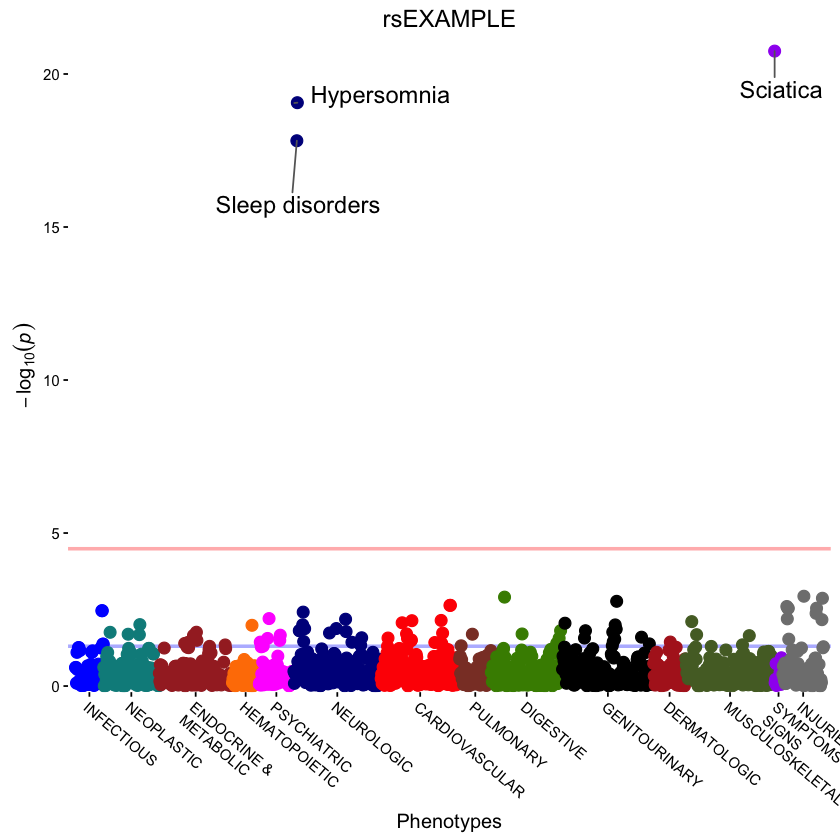

In [10]:
summarization_all(phenotypes, genotypes, results)

## 7. Exercises

We have provided three more example datasets - the code below will help you load them. Try writing your own code to run PheWAS on one or more of them - can you find a signal?

In [ ]:
data(testset1) # Load testset 1. 
genotypes=testset1$genotypes # Extract the genotypes
id.icd9.count=testset1$id.icd9.count # Extract the ICD-9 table
genotypes[1:10,]
id.icd9.count[1:10,]
phenotypes=create_phewas_table(id.icd9.count) # Create the PheWAS table
results=phewas_with_bonferroni(phenotypes, genotypes) # Run the PheWAS
phewas_manhattan(results) # Plot the results
summarization_table(phenotypes,genotypes,results)
summarization_paragraph(phenotypes,genotypes,results)
summarization_all(phenotypes,genotypes,results)
filter(results,bonferroni&!is.na(p)) # List the significant results

In [ ]:
ex2=data(testset2) # Load testset 2
# Extract the genotypes
# Extract the ICD-9 table
# Create the PheWAS table
# Run the PheWAS
# Plot the results
# Add PheWAS descriptions
# List the significant results, using whatever method you like best

In [ ]:
ex3=data(testset3) # Load testset 3 - the rest is up to you!

Mapping ICD-9 codes to PheWAS codes...
Aggregating PheWAS codes...
Mapping exclusions...
Joining, by = "exclusion_criteria"
Coalescing exclusions and min.code.count as applicable...
Reshaping data...
Merging data using these shared columns:  id
Finding associations...
Compiling results...
Cleaning up...
Finding significance thresholds...


The SNP rsEXAMPLE is significantly associated with Sleep disorders (PheWAS code 327) with a p-value of 1.52e-18 after Bonferroni correction.
--> PheWAS code 327 includes the following ICD-9 code(s): 327.52, 327.35, 307.4, 327.11, 327.30, 307.47, 780.5, 307.49, 327, 327.4, 327.32, 327.33, 327.44, 327.02, 307.44, 327.09, 327.42, 780.59, 327.1, 327.3, 327.5, 327.59, 327.22, 780.52, 780.58, 327.10, 327.49, 327.27, 307.43, 327.37, 327.24, 307.40, 327.25, 327.12, 327.41, 327.8, 780.54, 327.13, 307.45, 333.94, 327.40, 307.46, 327.14, 327.01, 327.26, 780.56, 327.23, 780.55, 327.34, 307.48, 327.43, 327.21, 307.42, 307.41, 327.00, 327.51, 327.19, 327.31, 327.36, 327.0, 780.50, 327.53, 327.39, 327.15

The SNP rsEXAMPLE is significantly associated with Hypersomnia (PheWAS code 327.1) with a p-value of 8.67e-20 after Bonferroni correction.
--> PheWAS code 327.1 includes the following ICD-9 code(s): 327.11, 307.44, 327.1, 327.10, 307.43, 327.12, 780.54, 327.13, 327.14, 327.19, 327.15

The SNP rsEXAM

Warning message:
“`rbind_all()` is deprecated. Please use `bind_rows()` instead.”

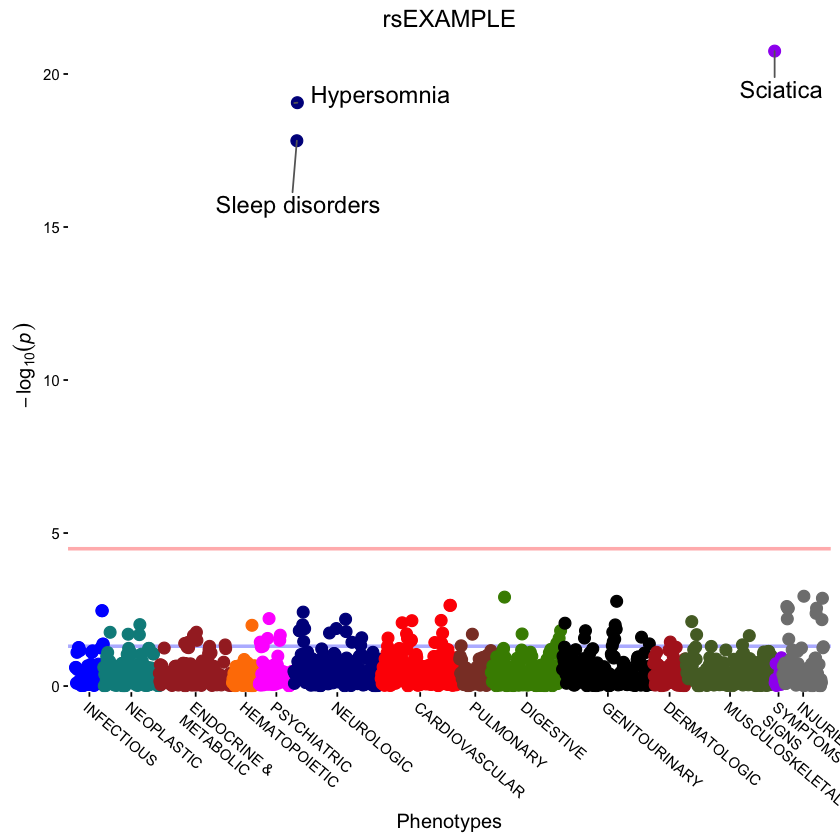

In [8]:
### Loading data
data(testset1) # Load testset 1. 
genotypes=testset1$genotypes # Extract the genotypes
id.icd9.count=testset1$id.icd9.count # Extract the ICD-9 table

### Running analysis
phenotypes=create_phewas_table(id.icd9.count) # Create the PheWAS table
results=phewas_with_bonferroni(phenotypes, genotypes) # Run the PheWAS
summarization_all(phenotypes,genotypes,results) # Output a Manhattan plot and a list summary of the results

## Appendix: Converting ICD-9 Codes to PheWAS Codes

If you'd like to convert an ICD-9 code to a PheWAS code, use the get_icd9_codes() function (below). For each code in the input list, it will output a list of PheWAS codes which include that ICD-9 code - you can choose which one best describes what you're looking for.

In [ ]:
get_icd9_codes(icd9_query=c("088.81", "327"))

## Basic simplePheWAS Run

The bare-bones PheWAS run.

In [46]:
data(testset3) # Load testset 3.
str(testset3)

List of 2
 $ id.icd9.count:'data.frame':	231359 obs. of  3 variables:
  ..$ id   : int [1:231359] 802 802 802 802 802 802 802 802 802 802 ...
  ..$ icd9 : chr [1:231359] "008.00" "005.4" "004.8" "005.2" ...
  ..$ count: num [1:231359] 2 2 5 6 1 5 10 3 1 4 ...
 $ genotypes    :'data.frame':	2000 obs. of  2 variables:
  ..$ id       : int [1:2000] 1 2 3 4 5 6 7 8 9 10 ...
  ..$ rsEXAMPLE: num [1:2000] 0 1 1 1 1 0 1 2 1 2 ...


In [47]:
genotypes=testset3$genotypes # Extract the genotypes
head(genotypes)

id,rsEXAMPLE
1,0
2,1
3,1
4,1
5,1
6,0


In [48]:
id.icd9.count=testset3$id.icd9.count # Extract the ICD-9 table
head(id.icd9.count)

id,icd9,count
802,008.00,2
802,005.4,2
802,004.8,5
802,005.2,6
802,005.9,1
802,008.3,5


In [49]:
phenotypes=create_phewas_table(id.icd9.count) # Create the PheWAS table
head(phenotypes)

Mapping ICD-9 codes to PheWAS codes...
Aggregating PheWAS codes...
Mapping exclusions...
Joining, by = "exclusion_criteria"
Coalescing exclusions and min.code.count as applicable...
Reshaping data...


id,008,008.5,008.51,008.52,008.6,008.7,010,031,031.1,⋯,985,986,987,988,989,990,994,994.1,994.2,994.21
1,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,NA,NA,NA,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
5,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
6,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [50]:
results=phewas_with_bonferroni(phenotypes, genotypes) # Run the PheWAS

Merging data using these shared columns:  id
Finding associations...
Compiling results...
Cleaning up...
Finding significance thresholds...


The SNP rsEXAMPLE is significantly associated with Benign neoplasm of ovary (PheWAS code 220) with a p-value of 4.13e-06 after Bonferroni correction.
--> PheWAS code 220 includes the following ICD-9 code(s): 220

    phewas_code       phewas_description       snp adjustment      beta
189         220 Benign neoplasm of ovary rsEXAMPLE       <NA> 0.3974757
            SE       OR            p     type n_total n_cases n_controls HWE_p
189 0.08632203 1.488064 4.133228e-06 logistic    1918     714       1204     1
    allele_freq n_no_snp note bonferroni
189   0.5114703        0            TRUE


For PheWAS code 220 (220):
--> Patients in dataset with phenotype: 714 (37.23% of total)
--> Odds ratio with SNP rsEXAMPLE: 1.488064
--> Of people presenting with Benign neoplasm of ovary: 11.2% have genotype 0, 67.65% have genotype 1, and 21.15% have genotype 2
--> Of people presenting without Benign neoplasm of ovary: 16.28% have genotype 0, 69.68% have genotype 1, and 14.04% have genotype 2
--> Of the 276 people with genotype 0: 28.99% have Benign neoplasm of ovary
--> Of the 1322 people with genotype 1: 36.54% have Benign neoplasm of ovary
--> Of the 320 people with genotype 2: 47.19% have Benign neoplasm of ovary



Warning message:
“`rbind_all()` is deprecated. Please use `bind_rows()` instead.”

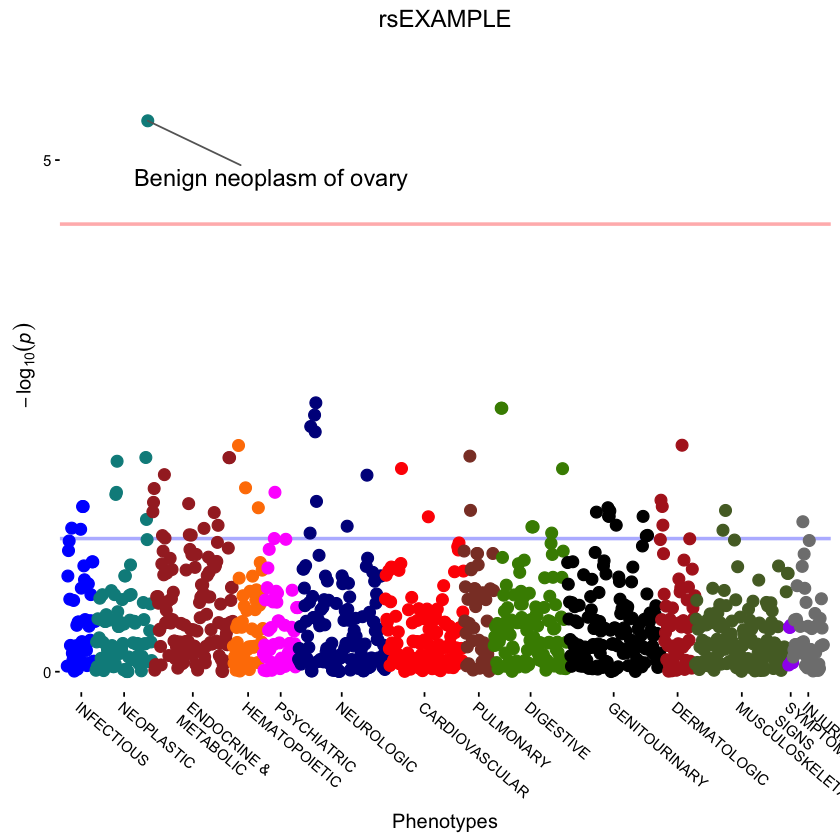

In [51]:
summarization_all(phenotypes,genotypes,results) # Output a Manhattan plot and a list summary of the results